In [102]:
import inspect
import os
import sys
from pathlib import Path

import analysis
import pandas as pd

# In Jupyter, __file__ is not defined, so use the current working directory
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import matcher

from frankenstein.tools import arithmetic, data_retrieval

ARITHMETIC_TOOL_NAMES = [name for name, _ in inspect.getmembers(arithmetic, predicate=inspect.isfunction)]
DATA_TOOL_NAMES = [name for name, _ in inspect.getmembers(data_retrieval, predicate=inspect.isfunction)]

run_dir = Path('runs')
dfs = {f.stem: pd.read_json(f, orient='records', lines=True, precise_float=True) for f in run_dir.iterdir()}
print(f'Found {len(dfs)} runs in {run_dir}:')

m = matcher.Matcher()

Found 54 runs in runs:


In [103]:
from tqdm import tqdm

summary_rows = []
for run_name, run_df in tqdm(dfs.items(), desc='Processing runs', unit='run'):
    # Compute tool call columns if not already present
    # Keep only rows where df['answer_format'] is not bool
    # run_df = run_df[run_df['answer_format'] != bool]
    if 'gold_tool_calls' not in run_df.columns:
        tools = DATA_TOOL_NAMES if 'data-tools' in run_name else []
        run_df['gold_tool_calls'] = run_df.apply(lambda row: analysis.get_gold_tool_calls(row, tools), axis=1)
    if 'pred_tool_calls' not in run_df.columns:
        run_df['pred_tool_calls'] = run_df.apply(analysis.get_pred_tool_calls, axis=1)
    if 'true_positives' not in run_df.columns:
        run_df['true_positives'] = run_df.apply(analysis.get_true_positives, axis=1)
    if 'false_positives' not in run_df.columns:
        run_df['false_positives'] = run_df.apply(analysis.get_false_positives, axis=1)
    if 'false_negatives' not in run_df.columns:
        run_df['false_negatives'] = run_df.apply(analysis.get_false_negatives, axis=1)
    if 'precision' not in run_df.columns:
        run_df['precision'] = run_df.apply(analysis.get_precision, axis=1)
    if 'coverage' not in run_df.columns:
        run_df['coverage'] = run_df.apply(analysis.get_coverage, axis=1)
    if 'error_made' not in run_df.columns:
        run_df['error_made'] = run_df.apply(analysis.get_error_made, axis=1)
    if 'correct_indicator_data_process' not in run_df.columns:
        run_df['correct_indicator_data_process'] = run_df.apply(analysis.get_correct_indicator_data_process, axis=1)

    summary = {
        'run': run_name,
        'n': len(run_df),
        'accuracy': run_df['correct'].mean() if 'correct' in run_df.columns else None,
        'precision_mean': run_df['precision'].mean(),
        'precision_std': run_df['precision'].std(),
        'coverage_mean': run_df['coverage'].mean(),
        'coverage_std': run_df['coverage'].std(),
        'error_rate': run_df['error_made'].mean(),
        'correct_indicator_data_process': run_df['correct_indicator_data_process'].mean(),
    }
    summary_rows.append(summary)

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(by='run')
summary_df = summary_df.round(2)  # Round to 2 decimal places

# Drop certain rows from the summary depending on the run name
summary_df = summary_df[~summary_df['run'].str.contains('Llama-3.1-70B|Llama-3.1-8B|Llama-3.2-3B')]
# Currently I have 'mean' and 'std' for precision and coverage, can I put these in a single column with a format like '0.85 ± 0.05'?
summary_df['precision'] = summary_df.apply(lambda row: rf'{row["precision_mean"]}$\pm${row["precision_std"]}', axis=1)
summary_df['coverage'] = summary_df.apply(lambda row: rf'{row["coverage_mean"]}$\pm${row["coverage_std"]}', axis=1)
summary_df = summary_df.drop(columns=['precision_mean', 'precision_std', 'coverage_mean', 'coverage_std'])
normal_runs = summary_df[~summary_df['run'].str.contains('data-tools|partial')]
zero_shot = normal_runs[normal_runs['run'].str.contains('0-shot')]
one_shot = normal_runs[normal_runs['run'].str.contains('1-shot')]
three_shot = normal_runs[normal_runs['run'].str.contains('3-shot')]
partial_runs = summary_df[summary_df['run'].str.contains('partial')]
data_tool_runs = summary_df[summary_df['run'].str.contains('data-tools')]
normal_runs

Processing runs: 100%|██████████| 54/54 [00:12<00:00,  4.38run/s]


,run,n,accuracy,error_rate,correct_indicator_data_process,precision,coverage
33,Llama-3.3-70B-Instruct_answerable-full_all-too...,400,0.39,0.34,0.20,0.33$\pm$0.39,0.28$\pm$0.37
16,Llama-3.3-70B-Instruct_answerable-full_all-too...,400,0.37,0.28,0.16,0.4$\pm$0.4,0.3$\pm$0.37
37,Llama-3.3-70B-Instruct_answerable-full_all-too...,400,0.28,0.20,0.07,0.3$\pm$0.38,0.19$\pm$0.3
52,Mistral-Small-3.1-24B_answerable-full_all-tool...,400,0.77,0.05,0.81,0.88$\pm$0.21,0.88$\pm$0.21
42,Mistral-Small-3.1-24B_answerable-full_all-tool...,400,0.79,0.06,0.82,0.88$\pm$0.21,0.87$\pm$0.21
51,Mistral-Small-3.1-24B_answerable-full_all-tool...,400,0.77,0.06,0.74,0.87$\pm$0.22,0.85$\pm$0.23
6,Qwen3-14B_answerable-full_all-tools_0-shot,400,0.58,0.19,0.66,0.85$\pm$0.26,0.72$\pm$0.28
15,Qwen3-14B_answerable-full_all-tools_1-shot,400,0.61,0.23,0.51,0.83$\pm$0.28,0.71$\pm$0.28
38,Qwen3-14B_answerable-full_all-tools_3-shot,400,0.57,0.44,0.37,0.78$\pm$0.29,0.67$\pm$0.29
43,Qwen3-30B-A3B_answerable-full_all-tools_0-shot,400,0.68,0.24,0.61,0.85$\pm$0.27,0.71$\pm$0.27


In [104]:
data_tool_runs

,run,n,accuracy,error_rate,correct_indicator_data_process,precision,coverage
41,Llama-3.3-70B-Instruct_answerable-full_data-to...,400,0.39,0.66,0.46,0.83$\pm$0.25,0.74$\pm$0.34
4,Mistral-Small-3.1-24B_answerable-full_data-too...,400,0.40,0.11,0.74,0.93$\pm$0.19,0.92$\pm$0.19
1,Qwen3-14B_answerable-full_data-tools_0-shot,400,0.38,0.33,0.64,0.85$\pm$0.27,0.82$\pm$0.29
49,Qwen3-30B-A3B_answerable-full_data-tools_0-shot,400,0.37,0.28,0.65,0.88$\pm$0.23,0.88$\pm$0.25
10,Qwen3-32B_answerable-full_data-tools_0-shot,400,0.74,0.29,0.70,0.92$\pm$0.18,0.92$\pm$0.19
24,Qwen3-4B_answerable-full_data-tools_0-shot,400,0.28,0.42,0.65,0.82$\pm$0.3,0.81$\pm$0.32
20,gpt-4.1-mini_answerable-full_data-tools_0-shot,400,0.50,0.20,0.53,0.9$\pm$0.19,0.92$\pm$0.16
11,gpt-4o-mini_answerable-full_data-tools_0-shot,400,0.36,0.52,0.35,0.69$\pm$0.35,0.75$\pm$0.33


In [105]:
partial_runs

,run,n,accuracy,error_rate,correct_indicator_data_process,precision,coverage
50,Llama-3.3-70B-Instruct_answerable-partial_all-...,260,0.38,0.54,0.37,0.41$\pm$0.39,0.31$\pm$0.38
12,Mistral-Small-3.1-24B_answerable-partial_all-t...,260,0.62,0.10,0.73,0.84$\pm$0.24,0.82$\pm$0.25
29,Qwen3-14B_answerable-partial_all-tools_0-shot,260,0.49,0.24,0.66,0.83$\pm$0.29,0.67$\pm$0.3
21,Qwen3-30B-A3B_answerable-partial_all-tools_0-shot,260,0.62,0.22,0.67,0.86$\pm$0.28,0.69$\pm$0.31
5,Qwen3-32B_answerable-partial_all-tools_0-shot,260,0.75,0.27,0.75,0.92$\pm$0.19,0.79$\pm$0.23
9,Qwen3-4B_answerable-partial_all-tools_0-shot,260,0.49,0.71,0.60,0.71$\pm$0.36,0.59$\pm$0.34
44,gpt-4.1-mini_answerable-partial_all-tools_0-shot,260,0.55,0.64,0.60,0.81$\pm$0.21,0.84$\pm$0.21
53,gpt-4o-mini_answerable-partial_all-tools_0-shot,260,0.49,0.71,0.46,0.6$\pm$0.31,0.68$\pm$0.32


In [106]:
error_rows = []
for run_name, run_df in tqdm(dfs.items(), desc='Processing runs', unit='run'):
    if 'error_made' not in run_df.columns:
        run_df['error_made'] = run_df.apply(analysis.get_error_made, axis=1)
    if 'correct' not in run_df.columns:
        run_df['correct'] = run_df.apply(lambda row: analysis.get_correct(row, m), axis=1)
    errors = {
        'run': run_name,
        # 'correct-and-error': ((run_df['correct'] == True) & (run_df['error_made'] == True)).sum(),
        # 'correct-and-no-error': ((run_df['correct'] == True) & (run_df['error_made'] == False)).sum(),
        # 'incorrect-and-error': ((run_df['correct'] == False) & (run_df['error_made'] == True)).sum(),
        # 'incorrect-and-no-error': ((run_df['correct'] == False) & (run_df['error_made'] == False)).sum(),
        'p_correct_given_no_error': ((run_df['correct'] == True) & (run_df['error_made'] == False)).sum()
        / ((run_df['error_made'] == False).sum() or 1),
        'p_correct_given_error': ((run_df['correct'] == True) & (run_df['error_made'] == True)).sum()
        / ((run_df['error_made'] == True).sum() or 1),
    }
    error_rows.append(errors)
error_df = pd.DataFrame(error_rows)
error_df = error_df.round(2)  # Round to 2 decimal places
error_df = error_df.sort_values(by='run')
error_df = error_df[~error_df['run'].str.contains('Llama-3.1-70B|Llama-3.1-8B|Llama-3.2-3B')]
error_df = error_df[error_df['run'].str.contains('answerable-full_all-tools_0-shot')]
# Remove 'answerable-full_all-tools_0-shot' from the run names
error_df['run'] = error_df['run'].str.replace('answerable-full_all-tools_0-shot', '', regex=False)
# Replace '-' and '_' with ' ' in the run names
error_df['run'] = error_df['run'].str.replace('-', ' ', regex=False)
error_df['run'] = error_df['run'].str.replace('_', ' ', regex=False)
# Replace column names with latex formatting p(correct | error) and p(correct | no error)
error_df = error_df.rename(
    columns={
        'p_correct_given_error': 'Error',
        'p_correct_given_no_error': 'No error',
    }
)
# error_df = error_df.rename(
#     columns={
#         'p_correct_given_error': r'$P(\text{correct} | \text{error})$',
#         'p_correct_given_no_error': r'$P(\text{correct} | \text{no error})$',
#     }
# )
error_df


Processing runs:   0%|          | 0/54 [00:00<?, ?run/s]

Processing runs: 100%|██████████| 54/54 [00:00<00:00, 1061.86run/s]


,run,No error,Error
33,Llama 3.3 70B Instruct,0.33,0.50
52,Mistral Small 3.1 24B,0.78,0.71
6,Qwen3 14B,0.63,0.37
43,Qwen3 30B A3B,0.74,0.51
17,Qwen3 32B,0.85,0.84
26,Qwen3 4B,0.64,0.58
22,gpt 4.1 mini,0.69,0.72
45,gpt 4o mini,0.66,0.70


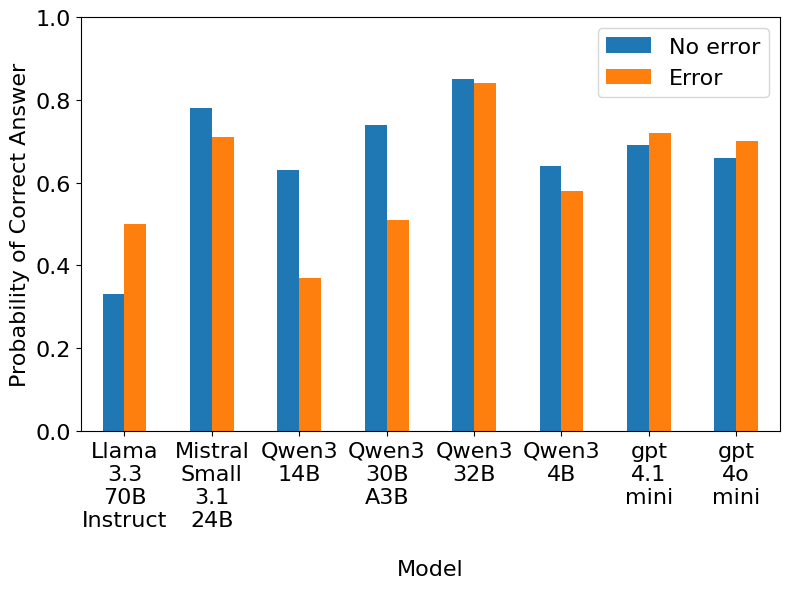

In [116]:
# ...existing code...
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
error_df['run'] = error_df['run'].apply(lambda x: x.replace(' ', '\n') if isinstance(x, str) else x)

error_df.plot(
    x='run',
    y=['No error', 'Error'],
    kind='bar',
    ax=ax,
    # color=['C2', 'C3'],
)
# Set x limit of 1.0 to avoid overlap of bars
ax.set_ylim(0, 1.0)
ax.set_ylabel('Probability of Correct Answer')
ax.set_xlabel('Model')
# Increase font size of the x-axis labels
ax.tick_params(axis='x', labelsize=16)
# Increase font size of the y-axis labels
ax.tick_params(axis='y', labelsize=16)
# Increase font size of y axis label
ax.set_ylabel('Probability of Correct Answer', fontsize=16)
# Increase font size of x axis label
ax.set_xlabel('Model', fontsize=16)
# Increase font size of the legend
ax.legend(fontsize=16)
# # Increase width of bars
# for bar in ax.patches:
#     bar.set_width(0.4)
# bar.set_x(bar.get_x() + 0.3)  # Adjust x position to center the bars

# ax.set_title('Effect of Error on Correct Answer Probability', fontsize=16)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('correct_answer_probability_with_and_without_error.png', dpi=300)
plt.show()

### [results.ipynb](vscode-remote://wsl/home/njf/code/frankenstein/eval/results.ipynb)

Add a new cell at the end to plot a bar chart comparing overall accuracy for `zero_shot` and `data_tool_runs`.



In [118]:
# ...existing code...
import matplotlib.pyplot as plt

zero_shot['run'] = zero_shot['run'].str.replace('answerable-full_all-tools_0-shot', '', regex=False)
zero_shot['run'] = zero_shot['run'].str.replace('-', ' ', regex=False)
zero_shot['run'] = zero_shot['run'].str.replace('_', ' ', regex=False)

data_tool_runs['run'] = data_tool_runs['run'].str.replace('answerable-full_data-tools_0-shot', '', regex=False)
data_tool_runs['run'] = data_tool_runs['run'].str.replace('-', ' ', regex=False)
data_tool_runs['run'] = data_tool_runs['run'].str.replace('_', ' ', regex=False)

# Prepare accuracy data for zero_shot and data_tool_runs
accuracy_df = pd.DataFrame(
    {
        # run is same in both zero_shot and data_tool_runs
        'run': zero_shot['run'],
        'All tools': list(zero_shot['accuracy']),
        'Data retrieval\ntools only': list(data_tool_runs['accuracy']),
    }
)
accuracy_df


/tmp/ipykernel_22816/2846645967.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_shot['run'] = zero_shot['run'].str.replace('answerable-full_all-tools_0-shot', '', regex=False)
/tmp/ipykernel_22816/2846645967.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_shot['run'] = zero_shot['run'].str.replace('-', ' ', regex=False)
/tmp/ipykernel_22816/2846645967.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

,run,All tools,Data retrieval\ntools only
33,Llama 3.3 70B Instruct,0.39,0.39
52,Mistral Small 3.1 24B,0.77,0.40
6,Qwen3 14B,0.58,0.38
43,Qwen3 30B A3B,0.68,0.37
17,Qwen3 32B,0.84,0.74
26,Qwen3 4B,0.60,0.28
22,gpt 4.1 mini,0.70,0.50
45,gpt 4o mini,0.68,0.36


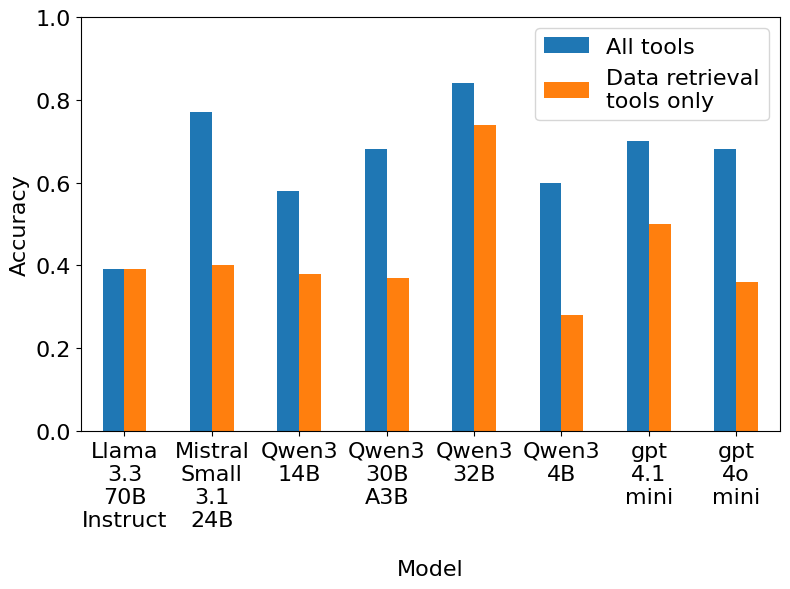

In [119]:
# Add line breaks to run names for readability
accuracy_df['run'] = accuracy_df['run'].apply(lambda x: x.replace(' ', '\n') if isinstance(x, str) else x)

fig, ax = plt.subplots(figsize=(8, 6))
accuracy_df.plot(
    x='run',
    y=['All tools', 'Data retrieval\ntools only'],
    kind='bar',
    ax=ax,
    # color=['C2', 'C3'],  # C2 is green, C3 is red
)
ax.set_ylim(0, 1.0)
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_xlabel('Model', fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(fontsize=16)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('overall_accuracy_zero_shot_vs_data_tools.png', dpi=300)
plt.show()
# ...existing code...